In [1]:
#!pip install tqdm pymc3 theano

In [4]:
%matplotlib inline
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.transforms import t_stick_breaking
from numpy import array

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
N = 1000 # seen annimals
S = 10 # sample periods
CH = []
GCH = []

In [3]:
#arrivals
#birth = torch.cat((torch.tensor([.5]), torch.zeros(S-1) + 0.1), 0) 
birth_init = np.concatenate(([40], np.zeros(S-1)+((100-40)/(S-1))), axis=0)
arr = pm.Dirichlet.dist(birth_init).random()

#departure
dep  = np.concatenate((np.ones(S-1) * (1-.4)/(S-1), [.4]), axis=0)

# Capture probability
prop = pm.Beta.dist(.5, 25).random(size = N)

In [4]:
dep, arr

(array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
        0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.4       ]),
 array([0.43422319, 0.05110617, 0.12178683, 0.05280738, 0.02380866,
        0.03423557, 0.04285729, 0.06449606, 0.06995446, 0.10472439]))

In [5]:
# Generate the data
Arrival_DIST = pm.Categorical.dist(arr)
for i in tqdm(range(N)):
    arrival = Arrival_DIST.random()
    dep_tmp = dep.copy()
    dep_tmp[:arrival] = 0
    #print(dep_tmp, arrival)
    departure = pm.Categorical.dist(dep_tmp).random() 
    dur = departure - arrival + 1
    capture_history = pm.Bernoulli.dist(prop[i]).random(size=(dur,1))
    capture_history = np.concatenate((np.zeros(arrival), 
                                      np.array(capture_history), 
                                      np.zeros(S - departure - 1)), 
                                     axis = 0)
    if capture_history.any():
        first = capture_history.argmax()
        last = S - capture_history[::-1].argmax() -1
        count = capture_history.sum()
        GCH.append([first, last, count])
        CH.append(capture_history)

100%|██████████| 1000/1000 [00:40<00:00, 24.64it/s]


In [6]:
import pickle
with open('gch.pkl', 'wb') as f:
  pickle.dump(GCH, f)

In [24]:
#import pickle
#with open('../gch.pkl', 'rb') as f:
#  GCH = pickle.load(f)

In [7]:
npdata = np.array(GCH, dtype = int)
V = len(GCH)
V

95

In [8]:
def get_vmask():
    v_mask = np.zeros([S,S,S])
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            v_mask[s,q]= np.concatenate((c1, c2, c3))
    return tt.constant(v_mask)

In [9]:
def get_imask():
    s_mask = np.zeros([V,S])
    q_mask = np.zeros([V,S])
    for w in np.arange(V):
        f, l = npdata[w, 0] , npdata[w, 1]
        s_mask[w] = np.concatenate((np.ones(f+1), np.zeros(S - f -1)))
        q_mask[w] = np.concatenate((np.zeros(l), np.ones(S-l)))
    i_mask = np.einsum("is,iq->isq", s_mask, q_mask)
    return tt.constant(i_mask)

In [10]:
def get_Risq(a,b):
    tmp_u = npdata[:, 2]
    expanded_u = tmp_u[:, np.newaxis, np.newaxis] *  np.ones((V, S, S)) # V x S x S
    d = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (V, S, S)) # V x S x S
    n = tt.constant(np.clip(d,a_min=0,a_max=S+1))
    n_u = np.triu(d - expanded_u, 0)
    n_u = tt.constant(np.clip(n_u,a_min=0,a_max=max(tmp_u))) # V x S x S
   
    
    # The beta binomial
    R_isq =   tt.gammaln(n+1)
    R_isq -=  tt.gammaln(expanded_u+1)
    R_isq -=  tt.gammaln(n_u+1)   
    R_isq +=  tt.gammaln(expanded_u+a)
    R_isq +=  tt.gammaln(n_u+b)
    R_isq -=  tt.gammaln(n+a+b)
    R_isq +=  tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)

    # The above is the computation of the log, so we take the exponent
    return tt.exp(R_isq)

In [11]:
def get_Risq0(a,b):
    # n = q - s + 1
    n = tt.constant(np.triu(np.ones([S,S]), 0).cumsum(axis =1))
    R0_sq = tt.exp(tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b))
    return R0_sq

In [12]:
def logp_capture(arr, phi, a, b, U):
    def ll_capture_f(mycaptures):
        phi_mask = get_vmask()  # S x S x S . all possible arrivals and departures for the "SURVIVAL"
        phi_v = tt.pow(1-phi, phi_mask)
        phi_v = tt.prod(phi_v, axis=2)
        #LD    = tt.einsum('s,sq,q->sq', A, phi_v, phi)
        LD = arr[:, np.newaxis] * phi_v * phi
        #LD_isq = tf.einsum('sq,isq->isq', LD, i_mask)
        i_mask   = get_imask()  # KxK   . matrix with real possible arrival and departures
        LD_isq = tt.mul(LD, i_mask) #
        
        R_isq = get_Risq(a, b) #
        
        Li = tt.batched_tensordot(LD_isq, R_isq, axes = 2) #
        
        # Likelihood of Not Capture
        v0_mask = 1 - phi_mask[0] # tihs is reuse
        LD0 = tt.mul(LD, v0_mask) #
        
        R0_sq = get_Risq0(a,b) #
        
        L0 = tt.sum(LD0 * R0_sq) #
        
        # Putting it together
        obj1 = tt.gammaln(tt.constant(V)+U+1.0) - tt.gammaln(U+1.0) - tt.gammaln(tt.constant(V)+ 1.0) #
        obj2 = tt.sum(tt.log(Li)) #
        obj3 = U * tt.log(L0) #

        objective = obj1 + obj2 +obj3 
        
        return objective
    
    return ll_capture_f

In [31]:
# custom log-liklihood
# model
with pm.Model() as model:
    # Hyper Params
    U = pm.DiscreteUniform('Unseen', lower=V, upper=5000)
    a = pm.Uniform('alpha', 0, 5)
    b  = pm.Uniform('beta', 5, 30)
    #alpha1 = pm.Uniform('alphaphi', 0, 100)
    #beta1  = pm.Uniform('betaphi',  0, 100)
    # Capture, Departure, Arrival probability
    # prop   = pm.Beta('propensity', alpha=alpha0, beta=beta0, shape=(V))
    #phi    = pm.Beta('survival',   alpha=alpha1, beta=beta1, shape=S)
    phi    = pm.Dirichlet('departure', a=np.array([1./S]*S), shape=S)
    arr    = pm.Dirichlet('arrival'  , a=np.array([1./S]*S), shape=S)
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U), observed=npdata)
    #MAP = pm.find_MAP()

In [32]:
#MAP

In [33]:
with model:
  #posterior = pm.sample(3, tune=0, chains=1, progressbar=False)
  step = pm.Metropolis()
  posterior = pm.sample(100000, step=step, n_jobs = 3)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [arrival]
>Metropolis: [departure]
>Metropolis: [beta]
>Metropolis: [alpha]
>Metropolis: [Unseen]
Sampling 4 chains: 100%|██████████| 402000/402000 [09:18<00:00, 719.40draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [0]:
#pm.find_MAP(model = model)

In [0]:
#test = [ob.logp(i) for i in posterior]


In [0]:
#counter = 0
#for i in posterior:
#  counter += 1
#  if counter % 500 == 0:
#    print(ob.logp(i))

/Users/ded/Documents/repositories/notebooks/venv/lib/python3.7/site-packages/pymc3/plots/energyplot.py:51: UserWarning: There is no energy information in the passed trace.
  warnings.warn('There is no energy information in the passed trace.')


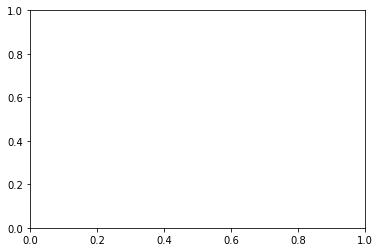

In [34]:
pm.energyplot(posterior);

In [35]:
#pm.plot_posterior(posterior, lw=0, alpha=0.5);


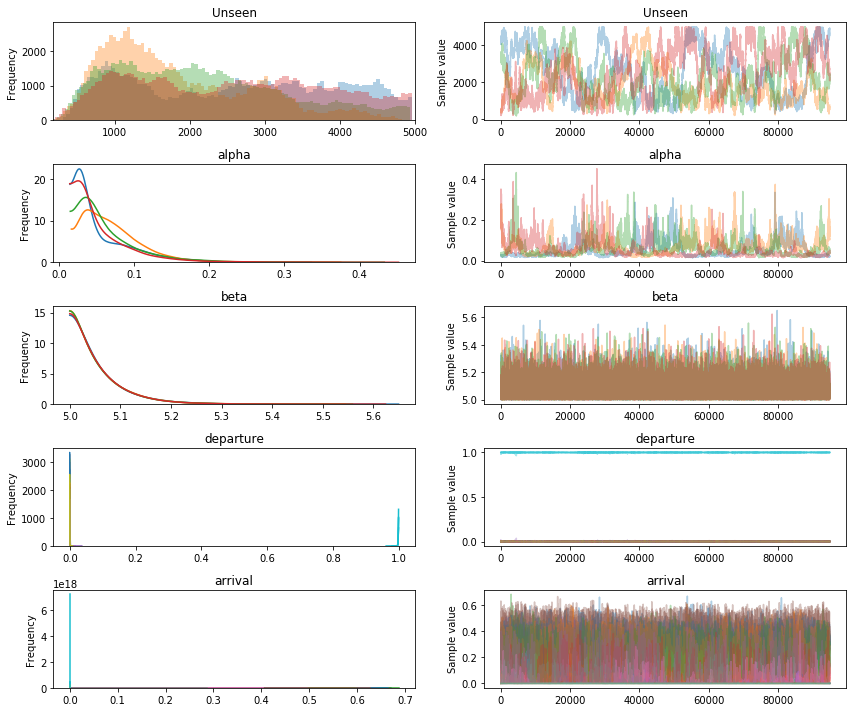

In [36]:
pm.traceplot(posterior[5000:]);

In [37]:
pm.summary(posterior).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,2286.30,1240.23,100.89,424.00,4614.00,56.85,1.05
alpha,0.06,0.04,0.00,0.02,0.15,111.39,1.02
beta,5.05,0.05,0.00,5.00,5.16,71660.07,1.00
departure__0,0.00,0.00,0.00,0.00,0.00,3005.99,1.00
departure__1,0.00,0.02,0.00,0.00,0.00,1805.50,1.00
departure__2,0.00,0.00,0.00,0.00,0.00,3623.04,1.00
departure__3,0.00,0.00,0.00,0.00,0.00,3975.37,1.00
departure__4,0.00,0.01,0.00,0.00,0.00,9432.59,1.00
departure__5,0.00,0.00,0.00,0.00,0.00,4171.16,1.00
departure__6,0.00,0.00,0.00,0.00,0.00,3479.23,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130c896d8>,
      dtype=object)

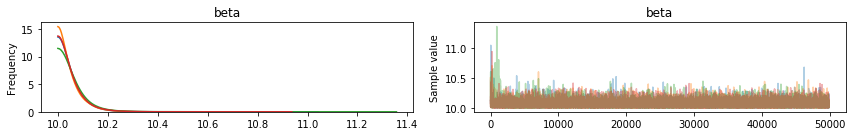

In [18]:
pm.plots.traceplot(posterior[100:], varnames=['beta'])

In [66]:
from pymc3 import summary
summary(posterior, varnames=['alpha', 'beta'])

/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python3.6/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.0,0.0,0.0,0.0,0.0,NaN,NaN
beta,100.0,0.0,0.0,100.0,100.0,NaN,NaN


In [68]:
posterior

<MultiTrace: 2 chains, 50000 iterations, 9 variables>

In [87]:
counter = 0
for i in posterior:
  counter += 1
  if counter % 500 == 0:
    print(ob.logp(i))

-405.28831039124634
-406.12692569050705
-403.7145354717504
-405.53096528106835
-409.06818119547097
-407.19463991431985
-405.2279709104041
-407.1482822879334
-406.5397125444142
-404.45332830562256


In [72]:
np.array([1./S]*S)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [40]:
birth_init

array([0.4       , 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

In [41]:
arr

arrival

In [42]:
dep

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.4       ])

In [58]:
xx = np.array([Arrival_DIST.random() for x in range(1000)])

In [64]:
u, c = np.unique(xx, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([108, 108, 106, 104, 106,  96,  94,  92,  94,  92]))

In [25]:
np.array([1./S]*S)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])